In [1]:
import random
import datetime
import pandas as pd
import numpy as np
from haversine import haversine
import folium
from datetime import datetime
import time
from tqdm import tqdm
import gc
import geopy.distance
import seaborn as sns
import shap
import matplotlib.pyplot as plt


## Data preprocessing

In [8]:
df1 = pd.read_csv("data/gps_fulldata_20220512_20220819.csv", encoding='shift_jis', engine = 'python', usecols=[0,1,2,4,6])
df1

,vehicleCode,lat,lng,timestamp,distance
0,W46-スポット,34.640898,133.966966,2022-05-12T10:17:32+09:00,0.000000
1,W46-スポット,34.640920,133.966956,2022-05-12T10:27:28+09:00,2.607085
2,W46-スポット,34.640933,133.966950,2022-05-12T10:48:50+09:00,1.543501
3,W46-スポット,34.641057,133.966894,2022-05-12T10:48:55+09:00,14.682787
4,W46-スポット,34.641229,133.966861,2022-05-12T10:49:00+09:00,19.319046
...,...,...,...,...,...
18876064,W1,35.082180,136.932447,2022-08-19T07:08:17+09:00,0.000000
18876065,W1,35.082399,136.932265,2022-08-19T07:08:29+09:00,29.424443
18876066,W1,35.082374,136.932283,2022-08-19T07:08:34+09:00,3.222924
18876067,W1,35.082375,136.932268,2022-08-19T07:08:40+09:00,1.372440


In [3]:
df2 = pd.read_csv("data/gps_20220820_20221107.csv", encoding='shift_jis', engine = 'python', header=None, usecols=[0,1,2,4,6], names=df1.columns)
df2

,vehicleCode,lat,lng,timestamp,distance
0,W46-スポット,34.640362,133.966977,2022-08-23T07:54:19+09:00,0.000000
1,W46-スポット,34.640391,133.966973,2022-08-23T07:54:33+09:00,0.000000
2,W46-スポット,34.640391,133.966973,2022-08-23T07:54:34+09:00,0.000000
3,W46-スポット,34.640651,133.967012,2022-08-23T08:04:27+09:00,29.063645
4,W46-スポット,34.640643,133.967039,2022-08-23T08:23:20+09:00,2.629780
...,...,...,...,...,...
14963701,W1,35.081417,136.931780,2022-11-04T18:37:21+09:00,12.617725
14963702,W1,35.081387,136.931712,2022-11-04T18:37:26+09:00,7.038125
14963703,W1,35.081454,136.931645,2022-11-04T18:37:31+09:00,9.622178
14963704,W1,35.081527,136.931603,2022-11-04T18:37:36+09:00,8.958866


In [4]:
df = pd.concat([df1, df2],axis=0)
df.sort_values(by=['vehicleCode', 'timestamp'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,vehicleCode,lat,lng,timestamp,distance
0,W1,35.081511,136.931423,2022-05-12T06:41:13+09:00,0.000000
1,W1,35.081820,136.931295,2022-05-12T06:49:47+09:00,36.214071
2,W1,35.081825,136.931280,2022-05-12T06:50:34+09:00,1.476148
3,W1,35.081957,136.931339,2022-05-12T06:50:39+09:00,15.601548
4,W1,35.082085,136.931459,2022-05-12T06:50:44+09:00,17.928186
...,...,...,...,...,...
33839770,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708
33839771,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719
33839772,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742
33839773,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303


In [5]:
del [[df1, df2]]
gc.collect()
df1 = pd.DataFrame()
df2 = pd.DataFrame()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33839775 entries, 0 to 33839774
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   vehicleCode  object 
 1   lat          float64
 2   lng          float64
 3   timestamp    object 
 4   distance     float64
dtypes: float64(3), object(2)
memory usage: 1.3+ GB


### Target Segment With Radi
- location : make tuple like (lat, lng)
- is_in_target : 
    - we have 4 target
    - i if location is in the target i (i = 1, 2, 3, 4)
    - 0 if not

We use only data passing through the target
- 33839775 rows -> 27092775 rows
- 93 vehicleCode -> 69 vehicleCode

In [7]:
def get_gps_distance(location, radi):
    for i in range(1, 5):
        if(haversine(location, target_place[str(i)]) < radi):
            return i
    return 0

In [8]:
target_place = {}
target_place['1'] = (35.50114245663584, 139.77058608966317)
target_place['2'] = (35.55767062747489, 139.6647807694566)
target_place['3'] = (35.47113783648265, 139.36696119089578)
target_place['4'] = (35.52031899275968, 139.35217137718712)

radi = 0.7 # 여러개로 실험 가능
df['is_in_target'] = df[['lat','lng']].apply(lambda x : get_gps_distance(tuple(x.values), radi), axis=1)
df.head()

,vehicleCode,lat,lng,timestamp,distance,is_in_target
0,W1,35.081511,136.931423,2022-05-12T06:41:13+09:00,0.000000,0
1,W1,35.081820,136.931295,2022-05-12T06:49:47+09:00,36.214071,0
2,W1,35.081825,136.931280,2022-05-12T06:50:34+09:00,1.476148,0
3,W1,35.081957,136.931339,2022-05-12T06:50:39+09:00,15.601548,0
4,W1,35.082085,136.931459,2022-05-12T06:50:44+09:00,17.928186,0


In [9]:
target_pass_result= list(df[df['is_in_target']!=0]['vehicleCode'].unique())
print(target_pass_result)

['W102', 'W103', 'W104', 'W105', 'W106', 'W108', 'W109', 'W110', 'W111', 'W112', 'W113', 'W114', 'W115', 'W117', 'W118', 'W119', 'W120-1', 'W120-2', 'W40-1', 'W40-2', 'W41-1', 'W41-2', 'W42-1', 'W42-2', 'W44-1', 'W44-2', 'W44-スポット', 'W45-1', 'W45-2', 'W46', 'W46-スポット', 'W47-1', 'W47-2', 'W47-3', 'W52', 'W53', 'W54', 'W69', 'W70', 'W71', 'W72', 'W73', 'W74', 'W75', 'W76', 'W77', 'W78', 'W79', 'W80', 'W82-2', 'W83-1', 'W83-2', 'W83-3', 'W84', 'W86', 'W87-1', 'W87-2', 'W88', 'W90', 'W91', 'W92-1', 'W93-1', 'W93-2', 'W94', 'W95-1', 'W95-2', 'W97-1', 'W97-2', 'W98-1', 'W98-2', '座間エンジン（1・2・4時区）-1', '座間エンジン（1・2・4時区）-2', '座間エンジン（3時区）-1', '座間エンジン（3時区）-2']


In [10]:
target_df= df[df['vehicleCode'].isin(target_pass_result)]
target_df.reset_index(drop=True, inplace=True)
target_df

,vehicleCode,lat,lng,timestamp,distance,is_in_target
0,W102,35.534938,139.651564,2022-05-12T03:49:19+09:00,40.923383,0
1,W102,35.534921,139.651580,2022-05-12T03:49:20+09:00,2.379729,0
2,W102,35.534921,139.651580,2022-05-12T03:49:24+09:00,0.000000,0
3,W102,35.534921,139.651580,2022-05-12T03:49:29+09:00,0.000000,0
4,W102,35.534976,139.651498,2022-05-12T03:49:31+09:00,9.619799,0
...,...,...,...,...,...,...
28043370,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708,0
28043371,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719,0
28043372,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742,0
28043373,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303,0


In [11]:
target_df['is_in_target'].value_counts(normalize=True)

0    0.927852
2    0.045563
1    0.010662
4    0.010287
3    0.005636
Name: is_in_target, dtype: float64

### Determination of arrival status
- del_time : Time difference between before and now
- course : In same vehicleCode, seperate different drive
    - criterion : del_time >= 3 hours
- segmentation_point : Get O at the moment the is_in_target changes
- final_seg_point : Get O at Estimated Arrivals (vehicle stop point)
    - method 1 : 10 minutes after entering the target area
    - method 2 : 12 times after entering the target area
    - method 3 : row which has max time_delta in the target area

In [12]:
import datetime
target_df['timestamp']=target_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x[:-6], '%Y-%m-%dt%H:%M:%S'))

serials = target_df['vehicleCode'].unique()
for serial in serials:
    target_df.loc[target_df.vehicleCode==serial, 'del_time'] = \
    np.append(0, (target_df.loc[target_df.vehicleCode==serial, 'timestamp'][1:].reset_index(drop=True)-target_df.loc[target_df.vehicleCode==serial, 'timestamp'][:-1].reset_index(drop=True)).apply(lambda x: x.seconds).values)

C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/994216547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['timestamp']=target_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x[:-6], '%Y-%m-%dt%H:%M:%S'))
C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/994216547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df.loc[target_df.vehicleCode==serial, 'del_time'] = \


In [13]:
# more than 3 hours -> new course
vehicleCodes=target_df['vehicleCode'].unique()
idx = list(target_df[target_df['del_time']>3*60*60].index)

for i in vehicleCodes:
    idx.append(target_df[target_df['vehicleCode']==i].index[0])
    
idx=sorted(list(set(idx)))

target_df.loc[0, 'course'] = 0
target_df.loc[idx, 'course'] = np.arange(1, len(idx)+1)
target_df['course'].fillna(method='ffill', inplace=True)

C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/2792932763.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df.loc[0, 'course'] = 0
C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/2792932763.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['course'].fillna(method='ffill', inplace=True)


In [14]:
target_df['temp'] = target_df['is_in_target'].shift(periods=1, fill_value=0)
target_df['segmentation_point'] = target_df.apply(lambda x : "O" if x['is_in_target']!= x['temp'] else "X", axis=1)

C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/3375457972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['temp'] = target_df['is_in_target'].shift(periods=1, fill_value=0)
C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/3375457972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['segmentation_point'] = target_df.apply(lambda x : "O" if x['is_in_target']!= x['temp'] else "X", axis=1)


In [15]:
from tqdm import tqdm
target_df['final_seg_point'] = "X"

# method 1
for i in tqdm(target_df[target_df['segmentation_point']=='O'].index):
    now = i
    while(target_df['course'][now]==target_df['course'][i]):
        now += 1
        if((target_df['timestamp'][now]-target_df['timestamp'][i]).total_seconds()>600):
            if(target_df['is_in_target'][now] == target_df['is_in_target'][i]):
                target_df.loc[now,'final_seg_point'] ='O'
                break
            else:
                break

# # method 2
# temp = target_df['is_in_target']
# for i in tqdm(target_df[target_df['segmentation_point']=='O'].index):
#     if (temp[i+1:i+13].sum() == temp[i+1]*12):
#         target_df.loc[i,'final_seg_point']="O"

C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/2516939612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['final_seg_point'] = "X"
100%|██████████| 37431/37431 [00:47<00:00, 780.62it/s] 


In [16]:
target_df['segmentation_point'].value_counts()

X    28005944
O       37431
Name: segmentation_point, dtype: int64

In [18]:
target_df['final_seg_point'].value_counts()

X    28012888
O       30487
Name: final_seg_point, dtype: int64

In [19]:
target_df.drop(['temp', 'segmentation_point'], axis=1, inplace=True)

C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/3443051309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df.drop(['temp', 'segmentation_point'], axis=1, inplace=True)


In [ ]:
target_df['course'] = target_df['course'].astype('int')

## feature
- velocity
- weekday
- velocity_mean_sec
- velocity_std_sec
- velocity_mean_day
- velocity_std_day
- left_time
- total_distance
- left_distance
- time_cum_sum
- total_time
- route_name

In [21]:
target_df['velocity'] = target_df['distance']/target_df['del_time']

C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/2732667640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['velocity'] = target_df['distance']/target_df['del_time']


In [30]:
for serial in tqdm(serials):
    del_x, del_y = [0], [0]
    for i, j in zip(target_df.loc[target_df.vehicleCode==serial, ['lat', 'lng']][1:].reset_index(drop=True).values, target_df.loc[target_df.vehicleCode==serial, ['lat', 'lng']][:-1].reset_index(drop=True).values):
        
        coords_1 = (i[0], (i[1]+j[1])/2)
        coords_2 = (j[0], (i[1]+j[1])/2)
        if i[0]>=j[0]:
            del_y.append(geopy.distance.geodesic(coords_1, coords_2).km*1000)
        else:del_y.append(geopy.distance.geodesic(coords_1, coords_2).km*-1000)
            
        coords_3 = ((i[0]+j[0])/2, i[1])
        coords_4 = ((i[0]+j[0])/2, j[1])
        if i[1]>=j[1]:
            del_x.append(geopy.distance.geodesic(coords_3, coords_4).km*1000)
        else:
            del_x.append(geopy.distance.geodesic(coords_3, coords_4).km*-1000)
    
    target_df.loc[target_df.vehicleCode==serial, 'del_x'] = del_x
    target_df.loc[target_df.vehicleCode==serial, 'del_y'] = del_y
    
    angle_list = []
    x1 = target_df.loc[target_df.vehicleCode==serial, 'del_x']/target_df.loc[target_df.vehicleCode==serial, 'distance'].to_numpy()
    y1 = target_df.loc[target_df.vehicleCode==serial, 'del_y']/target_df.loc[target_df.vehicleCode==serial, 'distance'].to_numpy()
    xy1 = np.stack((x1, y1), axis=1)
    xy2 = np.stack((x1.shift(1), y1.shift(1)), axis=1)
    
    for i, j in zip(xy1, xy2):
        angle_list.append(np.arccos(np.dot(i, j)))
        
    target_df.loc[target_df.vehicleCode==serial, 'angle'] = angle_list

  0%|                                                                                           | 0/69 [00:00<?, ?it/s]<ipython-input-30-e6e8953ec266>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df.loc[target_df.vehicleCode==serial, 'del_x'] = del_x
<ipython-input-30-e6e8953ec266>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df.loc[target_df.vehicleCode==serial, 'del_y'] = del_y
<ipython-input-30-e6e8953ec266>:28: RuntimeWarning: invalid value encountered in arccos
  angle_list.appe

 41%|███████████████████████████████▏                                             | 28/69 [1:04:40<2:15:05, 197.68s/it]<ipython-input-30-e6e8953ec266>:28: RuntimeWarning: invalid value encountered in arccos
  angle_list.append(np.arccos(np.dot(i, j)))
 42%|████████████████████████████████▎                                            | 29/69 [1:08:18<2:15:50, 203.75s/it]<ipython-input-30-e6e8953ec266>:28: RuntimeWarning: invalid value encountered in arccos
  angle_list.append(np.arccos(np.dot(i, j)))
 43%|█████████████████████████████████▍                                           | 30/69 [1:12:01<2:16:12, 209.55s/it]<ipython-input-30-e6e8953ec266>:28: RuntimeWarning: invalid value encountered in arccos
  angle_list.append(np.arccos(np.dot(i, j)))
 45%|██████████████████████████████████▌                                          | 31/69 [1:14:27<2:00:31, 190.29s/it]<ipython-input-30-e6e8953ec266>:28: RuntimeWarning: invalid value encountered in arccos
  angle_list.append(np.arccos(np.dot(

 88%|███████████████████████████████████████████████████████████████████▏        | 61/69 [5:53:10<9:18:56, 4192.01s/it]<ipython-input-30-e6e8953ec266>:28: RuntimeWarning: invalid value encountered in arccos
  angle_list.append(np.arccos(np.dot(i, j)))
 90%|████████████████████████████████████████████████████████████████████▎       | 62/69 [5:56:31<5:49:24, 2994.86s/it]<ipython-input-30-e6e8953ec266>:28: RuntimeWarning: invalid value encountered in arccos
  angle_list.append(np.arccos(np.dot(i, j)))
 91%|█████████████████████████████████████████████████████████████████████▍      | 63/69 [5:59:43<3:35:23, 2153.87s/it]<ipython-input-30-e6e8953ec266>:28: RuntimeWarning: invalid value encountered in arccos
  angle_list.append(np.arccos(np.dot(i, j)))
 93%|██████████████████████████████████████████████████████████████████████▍     | 64/69 [6:00:09<2:06:17, 1515.47s/it]<ipython-input-30-e6e8953ec266>:28: RuntimeWarning: invalid value encountered in arccos
  angle_list.append(np.arccos(np.dot(

In [26]:
target_df['weekday'] = target_df['timestamp'].dt.weekday
target_df['five_sec'] = target_df['timestamp'].dt.round('5s').dt.time
target_df['five_sec'] = target_df['five_sec'].apply(lambda x: x.strftime("%H:%M:%S"))
target_df = target_df.fillna(0)
target_df.loc[target_df['velocity']==np.inf, 'velocity'] = 0

In [27]:
a = target_df.groupby('five_sec')['velocity'].mean()
b = target_df.groupby('five_sec')['velocity'].std()
c = target_df.groupby('weekday')['velocity'].mean()
d = target_df.groupby('weekday')['velocity'].std()

In [68]:
target_df = pd.merge(target_df, a, on='five_sec', how='left', suffixes=('', '_mean_sec'))
target_df = pd.merge(target_df, b, on='five_sec', how='left', suffixes=('', '_std_sec'))
target_df = pd.merge(target_df, c, on='weekday', how='left', suffixes=('', '_mean_day'))
target_df = pd.merge(target_df, d, on='weekday', how='left', suffixes=('', '_std_day'))

In [25]:
target_df['cum_sum'] = target_df.groupby("course").distance.cumsum()

#total distance per course
total_distance = target_df.groupby("course").distance.sum()

# mapping target_df with total distance per course
target_df['total_distance']= target_df.course.apply(lambda x : total_distance[x])

# left_distance per course
target_df['left_distance'] = target_df['total_distance'] - target_df['cum_sum']

In [30]:
#accumulative time from beginning
target_df['time_cum_sum'] = target_df.groupby("course").del_time.cumsum()

#total time_consumption per course
total_time = target_df.groupby("course").del_time.sum()

# mapping target_df with total tite_consumption per course
target_df['total_time']= target_df.course.apply(lambda x : total_time[x])

# left_time per course
target_df['left_time'] = target_df['total_time'] - target_df['time_cum_sum']

In [31]:
target_df['start']=target_df['is_in_target']
target_df['end']=target_df['is_in_target']
target_df['start'].replace(0, np.NaN,inplace=True)
target_df['end'].replace(0, np.NaN,inplace=True)

courses=target_df['course'].unique()
courses.sort()


idx=[]
for i in courses:
    idx.append(target_df[target_df['course']==i].index[0])
target_df.loc[idx, 'start'] = 0
target_df.loc[idx, 'end'] = 0


if np.isnan(target_df['end'].iloc[-1]):
    target_df['end'].iloc[-1]=0
target_df['start'].fillna(method='ffill', inplace=True)
target_df['end'].fillna(method='bfill', inplace=True)

target_df['route_name']=target_df['start'].astype('int').astype('str')+target_df['end'].astype('int').astype('str')+target_df['vehicleCode']

C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/1568121440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['start'].replace(0, np.NaN,inplace=True)
C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/1568121440.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['end'].replace(0, np.NaN,inplace=True)
C:\Users\rkd20\AppData\Local\Temp/ipykernel_44772/1568121440.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [69]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28043375 entries, 0 to 28043374
Data columns (total 25 columns):
 #   Column             Dtype         
---  ------             -----         
 0   vehicleCode        object        
 1   lat                float64       
 2   lng                float64       
 3   timestamp          datetime64[ns]
 4   distance           float64       
 5   is_in_target       int64         
 6   del_time           float64       
 7   course             float64       
 8   final_seg_point    object        
 9   velocity           float64       
 10  weekday            int64         
 11  cum_sum            float64       
 12  total_distance     float64       
 13  left_distance      float64       
 14  five_sec           object        
 15  velocity_mean_sec  float64       
 16  velocity_std_sec   float64       
 17  time_cum_sum       float64       
 18  total_time         float64       
 19  left_time          float64       
 20  start              int

In [78]:
target_df.to_csv("preprocessed_dataset.csv", index =False)

## Modeling

In [3]:
#import preprocessed_Dataset
data = pd.read_csv("preprocessed_dataset.csv")
data.head()

,vehicleCode,lat,lng,timestamp,distance,is_in_target,del_time,course,final_seg_point,velocity,...,velocity_mean_sec,velocity_std_sec,time_cum_sum,total_time,left_time,start,end,route_name,velocity_mean_day,velocity_std_day
0,W102,35.534938,139.651564,2022-05-12 03:49:19,40.923383,0,0.0,1.0,X,0.000000,...,12.714170,8.451423,0.0,46228.0,46228.0,0,0,00W102,14.855929,1382.331636
1,W102,35.534921,139.651580,2022-05-12 03:49:20,2.379729,0,1.0,1.0,X,2.379729,...,12.714170,8.451423,1.0,46228.0,46227.0,0,0,00W102,14.855929,1382.331636
2,W102,35.534921,139.651580,2022-05-12 03:49:24,0.000000,0,4.0,1.0,X,0.000000,...,12.761010,9.212827,5.0,46228.0,46223.0,0,0,00W102,14.855929,1382.331636
3,W102,35.534921,139.651580,2022-05-12 03:49:29,0.000000,0,5.0,1.0,X,0.000000,...,14.166098,40.625645,10.0,46228.0,46218.0,0,0,00W102,14.855929,1382.331636
4,W102,35.534976,139.651498,2022-05-12 03:49:31,9.619799,0,2.0,1.0,X,4.809900,...,14.166098,40.625645,12.0,46228.0,46216.0,0,0,00W102,14.855929,1382.331636


In [4]:
# in our model, only certain feature will be used (below features)
final_data=data[['vehicleCode', 'lat', 'lng', 'velocity', 'distance', 'is_in_target','course','total_distance','left_distance', 'time_cum_sum', 'total_time','route_name','weekday', 'velocity_mean_sec', 'velocity_std_sec','velocity_mean_day', 'velocity_std_day','left_time']]

In [5]:
# make y value into minutes scale
final_data['left_time'] = final_data['left_time'].apply(lambda x : int(x/60))
final_data

C:\Users\rkd20\AppData\Local\Temp/ipykernel_44412/355547265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['left_time'] = final_data['left_time'].apply(lambda x : int(x/60))


,vehicleCode,lat,lng,velocity,distance,is_in_target,course,total_distance,left_distance,time_cum_sum,total_time,route_name,weekday,velocity_mean_sec,velocity_std_sec,velocity_mean_day,velocity_std_day,left_time
0,W102,35.534938,139.651564,0.000000,40.923383,0,1.0,121048.108219,121007.184836,0.0,46228.0,00W102,3,12.714170,8.451423,14.855929,1382.331636,770
1,W102,35.534921,139.651580,2.379729,2.379729,0,1.0,121048.108219,121004.805107,1.0,46228.0,00W102,3,12.714170,8.451423,14.855929,1382.331636,770
2,W102,35.534921,139.651580,0.000000,0.000000,0,1.0,121048.108219,121004.805107,5.0,46228.0,00W102,3,12.761010,9.212827,14.855929,1382.331636,770
3,W102,35.534921,139.651580,0.000000,0.000000,0,1.0,121048.108219,121004.805107,10.0,46228.0,00W102,3,14.166098,40.625645,14.855929,1382.331636,770
4,W102,35.534976,139.651498,4.809900,9.619799,0,1.0,121048.108219,120995.185308,12.0,46228.0,00W102,3,14.166098,40.625645,14.855929,1382.331636,770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28043370,座間エンジン（3時区）-2,35.501584,139.439746,0.824342,4.121708,0,8951.0,144967.756394,20.369249,91632.0,91653.0,00座間エンジン（3時区）-2,4,15.459545,59.483187,12.702904,49.704713,0
28043371,座間エンジン（3時区）-2,35.501576,139.439728,0.309787,1.858719,0,8951.0,144967.756394,18.510530,91638.0,91653.0,00座間エンジン（3時区）-2,4,18.548741,123.468030,12.702904,49.704713,0
28043372,座間エンジン（3時区）-2,35.501510,139.439645,2.100748,10.503742,0,8951.0,144967.756394,8.006789,91643.0,91653.0,00座間エンジン（3時区）-2,4,16.145609,48.045460,12.702904,49.704713,0
28043373,座間エンジン（3時区）-2,35.501472,139.439588,1.334461,6.672303,0,8951.0,144967.756394,1.334485,91648.0,91653.0,00座間エンジン（3時区）-2,4,16.078983,59.840919,12.702904,49.704713,0


### For making model more precisely, select validated course data

- By using IQR, delete the course that has too less timestamp
- Only course that passing through 4 of target place will be considered

In [6]:
s = pd.DataFrame(data.groupby("course")['is_in_target'])
not_pass_target = []
for i in range(len(s)):
    if(s.iloc[i][1].sum()==0):
        not_pass_target.append(i+1)

In [7]:
len(not_pass_target)

2374

In [8]:
final_data = final_data[~final_data['course'].isin(not_pass_target)]
final_data.head()

,vehicleCode,lat,lng,velocity,distance,is_in_target,course,total_distance,left_distance,time_cum_sum,total_time,route_name,weekday,velocity_mean_sec,velocity_std_sec,velocity_mean_day,velocity_std_day,left_time
0,W102,35.534938,139.651564,0.000000,40.923383,0,1.0,121048.108219,121007.184836,0.0,46228.0,00W102,3,12.714170,8.451423,14.855929,1382.331636,770
1,W102,35.534921,139.651580,2.379729,2.379729,0,1.0,121048.108219,121004.805107,1.0,46228.0,00W102,3,12.714170,8.451423,14.855929,1382.331636,770
2,W102,35.534921,139.651580,0.000000,0.000000,0,1.0,121048.108219,121004.805107,5.0,46228.0,00W102,3,12.761010,9.212827,14.855929,1382.331636,770
3,W102,35.534921,139.651580,0.000000,0.000000,0,1.0,121048.108219,121004.805107,10.0,46228.0,00W102,3,14.166098,40.625645,14.855929,1382.331636,770
4,W102,35.534976,139.651498,4.809900,9.619799,0,1.0,121048.108219,120995.185308,12.0,46228.0,00W102,3,14.166098,40.625645,14.855929,1382.331636,770


In [9]:
temp = pd.DataFrame(final_data.groupby(['vehicleCode','course']).count())

Q1 = temp.groupby("vehicleCode")['lat'].describe()["25%"]
Q3 = temp.groupby("vehicleCode")['lat'].describe()["75%"]
IQR = Q3-Q1
min_limit = Q1-1.5*IQR
min_limit_dic = {}

for _,b in enumerate(min_limit.items()):
    min_limit_dic[b[0]] =b[1]

In [10]:
min_limit_dic

{'W102': 2527.25,
 'W103': -1073.5,
 'W104': 1351.75,
 'W105': 883.25,
 'W106': 1587.5,
 'W108': 3466.0,
 'W109': 3716.5,
 'W110': -3317.5,
 'W111': 1738.5,
 'W112': 1017.625,
 'W113': 2024.75,
 'W114': 2384.25,
 'W115': 1071.25,
 'W117': 845.875,
 'W118': 94.0,
 'W119': 2286.5,
 'W120-1': -1074.0,
 'W120-2': 785.0,
 'W40-1': -2215.5,
 'W40-2': -4454.0,
 'W41-1': 2265.5,
 'W41-2': -3393.875,
 'W42-1': 2485.75,
 'W42-2': -2931.125,
 'W44-1': 4038.0,
 'W44-2': 4821.0,
 'W44-スポット': 1665.75,
 'W45-1': 5395.5,
 'W45-2': 4557.125,
 'W46': 4372.375,
 'W46-スポット': 847.125,
 'W47-1': 2970.625,
 'W47-2': -2875.0,
 'W47-3': 3402.375,
 'W52': 1880.375,
 'W53': 1355.625,
 'W54': 1843.5,
 'W69': 2750.75,
 'W70': 2583.25,
 'W71': 242.5,
 'W72': 1728.25,
 'W73': 3923.0,
 'W74': 3883.5,
 'W75': -804.75,
 'W76': 1384.0,
 'W77': 1801.75,
 'W78': 3841.0,
 'W79': 1865.0,
 'W80': 1752.5,
 'W82-2': 3674.5,
 'W83-1': 66.0,
 'W83-2': 2191.5,
 'W83-3': 5037.875,
 'W84': 2188.625,
 'W86': 1480.0,
 'W87-1': 796.12

In [11]:
s = final_data.groupby(['vehicleCode',"course"])['vehicleCode'].count()
not_used = []
for key in min_limit_dic.keys():
    for _,i in enumerate(s[key].items()):        
        if(i[1]<min_limit_dic[key]):
            not_used.append(i[0])
len(not_used)

256

In [12]:
selected_data = final_data[~final_data['course'].isin(not_used)]
selected_data

,vehicleCode,lat,lng,velocity,distance,is_in_target,course,total_distance,left_distance,time_cum_sum,total_time,route_name,weekday,velocity_mean_sec,velocity_std_sec,velocity_mean_day,velocity_std_day,left_time
0,W102,35.534938,139.651564,0.000000,40.923383,0,1.0,121048.108219,121007.184836,0.0,46228.0,00W102,3,12.714170,8.451423,14.855929,1382.331636,770
1,W102,35.534921,139.651580,2.379729,2.379729,0,1.0,121048.108219,121004.805107,1.0,46228.0,00W102,3,12.714170,8.451423,14.855929,1382.331636,770
2,W102,35.534921,139.651580,0.000000,0.000000,0,1.0,121048.108219,121004.805107,5.0,46228.0,00W102,3,12.761010,9.212827,14.855929,1382.331636,770
3,W102,35.534921,139.651580,0.000000,0.000000,0,1.0,121048.108219,121004.805107,10.0,46228.0,00W102,3,14.166098,40.625645,14.855929,1382.331636,770
4,W102,35.534976,139.651498,4.809900,9.619799,0,1.0,121048.108219,120995.185308,12.0,46228.0,00W102,3,14.166098,40.625645,14.855929,1382.331636,770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28043370,座間エンジン（3時区）-2,35.501584,139.439746,0.824342,4.121708,0,8951.0,144967.756394,20.369249,91632.0,91653.0,00座間エンジン（3時区）-2,4,15.459545,59.483187,12.702904,49.704713,0
28043371,座間エンジン（3時区）-2,35.501576,139.439728,0.309787,1.858719,0,8951.0,144967.756394,18.510530,91638.0,91653.0,00座間エンジン（3時区）-2,4,18.548741,123.468030,12.702904,49.704713,0
28043372,座間エンジン（3時区）-2,35.501510,139.439645,2.100748,10.503742,0,8951.0,144967.756394,8.006789,91643.0,91653.0,00座間エンジン（3時区）-2,4,16.145609,48.045460,12.702904,49.704713,0
28043373,座間エンジン（3時区）-2,35.501472,139.439588,1.334461,6.672303,0,8951.0,144967.756394,1.334485,91648.0,91653.0,00座間エンジン（3時区）-2,4,16.078983,59.840919,12.702904,49.704713,0


### train, test split

- split the dataset into (train, test) with course-wise by vehicleCode


In [13]:
import random
temp = pd.DataFrame(selected_data.groupby("vehicleCode").course)

test_course = []
for i in range(len(temp)):
    t = temp[1][i].values
    set_t = set(t)
    idx = random.sample(set_t,int(len(set_t)/8))
    set_t = list(set_t)
    test_course.extend(idx)
    

C:\Users\rkd20\AppData\Local\Temp/ipykernel_44412/2339961537.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  idx = random.sample(set_t,int(len(set_t)/8))


In [14]:
test_data = selected_data[selected_data['course'].isin(test_course)]
train_data = selected_data[~selected_data['course'].isin(test_course)]
print("train_data len is {}".format(len(train_data)))
print("test_data len is {}".format(len(test_data)))

train_data len is 18882329
test_data len is 2498233


In [15]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
seed =1422
model1= CatBoostRegressor(
                          eval_metric = 'RMSE',
                          cat_features = ['vehicleCode','route_name','is_in_target','weekday'],
                          random_state=seed,
                         verbose = True)

X_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]
X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

model1.fit(X_train , y_train)

Learning rate set to 0.193998
0:	learn: 287.1569510	total: 8.36s	remaining: 2h 19m 16s
1:	learn: 248.3261894	total: 14.7s	remaining: 2h 2m 4s
2:	learn: 216.3978216	total: 20.8s	remaining: 1h 55m 20s
3:	learn: 189.6922692	total: 27.1s	remaining: 1h 52m 15s
4:	learn: 169.0492755	total: 32.3s	remaining: 1h 46m 58s
5:	learn: 152.2567772	total: 36.8s	remaining: 1h 41m 32s
6:	learn: 138.7773302	total: 40.3s	remaining: 1h 35m 12s
7:	learn: 127.3604144	total: 44.2s	remaining: 1h 31m 17s
8:	learn: 117.3001058	total: 47.6s	remaining: 1h 27m 24s
9:	learn: 108.3505734	total: 51.6s	remaining: 1h 25m 5s
10:	learn: 100.7336172	total: 55.1s	remaining: 1h 22m 37s
11:	learn: 94.8194658	total: 58.6s	remaining: 1h 20m 26s
12:	learn: 90.0190490	total: 1m 2s	remaining: 1h 18m 39s
13:	learn: 84.8747964	total: 1m 5s	remaining: 1h 17m 23s
14:	learn: 80.7356740	total: 1m 9s	remaining: 1h 15m 33s
15:	learn: 77.0133121	total: 1m 12s	remaining: 1h 14m 5s
16:	learn: 74.3738435	total: 1m 15s	remaining: 1h 13m 8s
17:

147:	learn: 20.3187330	total: 8m 56s	remaining: 51m 30s
148:	learn: 20.2557657	total: 9m	remaining: 51m 26s
149:	learn: 20.1941430	total: 9m 3s	remaining: 51m 20s
150:	learn: 20.1042908	total: 9m 7s	remaining: 51m 16s
151:	learn: 20.0184562	total: 9m 11s	remaining: 51m 14s
152:	learn: 19.9495426	total: 9m 14s	remaining: 51m 10s
153:	learn: 19.8993316	total: 9m 18s	remaining: 51m 6s
154:	learn: 19.8332080	total: 9m 21s	remaining: 51m 1s
155:	learn: 19.7739022	total: 9m 25s	remaining: 50m 57s
156:	learn: 19.7088047	total: 9m 28s	remaining: 50m 52s
157:	learn: 19.6426221	total: 9m 32s	remaining: 50m 48s
158:	learn: 19.5840376	total: 9m 35s	remaining: 50m 42s
159:	learn: 19.5297320	total: 9m 38s	remaining: 50m 37s
160:	learn: 19.4745559	total: 9m 41s	remaining: 50m 31s
161:	learn: 19.4130786	total: 9m 45s	remaining: 50m 27s
162:	learn: 19.3650009	total: 9m 48s	remaining: 50m 22s
163:	learn: 19.3142777	total: 9m 52s	remaining: 50m 19s
164:	learn: 19.2495425	total: 9m 55s	remaining: 50m 15s


293:	learn: 14.3219296	total: 17m 21s	remaining: 41m 41s
294:	learn: 14.3008518	total: 17m 24s	remaining: 41m 37s
295:	learn: 14.2689404	total: 17m 28s	remaining: 41m 33s
296:	learn: 14.2492456	total: 17m 31s	remaining: 41m 29s
297:	learn: 14.2310466	total: 17m 35s	remaining: 41m 25s
298:	learn: 14.2092036	total: 17m 38s	remaining: 41m 21s
299:	learn: 14.1792239	total: 17m 41s	remaining: 41m 17s
300:	learn: 14.1614008	total: 17m 44s	remaining: 41m 13s
301:	learn: 14.1445440	total: 17m 48s	remaining: 41m 8s
302:	learn: 14.1089230	total: 17m 51s	remaining: 41m 5s
303:	learn: 14.0814858	total: 17m 55s	remaining: 41m 1s
304:	learn: 14.0591798	total: 17m 58s	remaining: 40m 58s
305:	learn: 14.0294550	total: 18m 2s	remaining: 40m 54s
306:	learn: 14.0053547	total: 18m 5s	remaining: 40m 51s
307:	learn: 13.9796525	total: 18m 9s	remaining: 40m 47s
308:	learn: 13.9522578	total: 18m 12s	remaining: 40m 43s
309:	learn: 13.9268254	total: 18m 16s	remaining: 40m 39s
310:	learn: 13.8999986	total: 18m 19s

438:	learn: 11.6563694	total: 25m 19s	remaining: 32m 22s
439:	learn: 11.6475150	total: 25m 23s	remaining: 32m 19s
440:	learn: 11.6324846	total: 25m 26s	remaining: 32m 15s
441:	learn: 11.6187130	total: 25m 29s	remaining: 32m 11s
442:	learn: 11.6094763	total: 25m 33s	remaining: 32m 7s
443:	learn: 11.5919040	total: 25m 36s	remaining: 32m 3s
444:	learn: 11.5763870	total: 25m 39s	remaining: 32m
445:	learn: 11.5592833	total: 25m 43s	remaining: 31m 56s
446:	learn: 11.5416958	total: 25m 46s	remaining: 31m 53s
447:	learn: 11.5307793	total: 25m 49s	remaining: 31m 49s
448:	learn: 11.5202641	total: 25m 52s	remaining: 31m 45s
449:	learn: 11.5004947	total: 25m 55s	remaining: 31m 41s
450:	learn: 11.4917120	total: 25m 59s	remaining: 31m 37s
451:	learn: 11.4795099	total: 26m 2s	remaining: 31m 34s
452:	learn: 11.4661676	total: 26m 5s	remaining: 31m 30s
453:	learn: 11.4551217	total: 26m 8s	remaining: 31m 26s
454:	learn: 11.4416170	total: 26m 12s	remaining: 31m 23s
455:	learn: 11.4302145	total: 26m 15s	re

583:	learn: 10.1015046	total: 33m 12s	remaining: 23m 39s
584:	learn: 10.0923706	total: 33m 15s	remaining: 23m 35s
585:	learn: 10.0832870	total: 33m 18s	remaining: 23m 32s
586:	learn: 10.0706129	total: 33m 22s	remaining: 23m 28s
587:	learn: 10.0618841	total: 33m 25s	remaining: 23m 25s
588:	learn: 10.0519637	total: 33m 28s	remaining: 23m 21s
589:	learn: 10.0449795	total: 33m 31s	remaining: 23m 18s
590:	learn: 10.0355586	total: 33m 35s	remaining: 23m 14s
591:	learn: 10.0251756	total: 33m 38s	remaining: 23m 11s
592:	learn: 10.0197474	total: 33m 41s	remaining: 23m 7s
593:	learn: 10.0133784	total: 33m 45s	remaining: 23m 4s
594:	learn: 10.0061964	total: 33m 48s	remaining: 23m 1s
595:	learn: 10.0013430	total: 33m 52s	remaining: 22m 57s
596:	learn: 9.9961394	total: 33m 55s	remaining: 22m 53s
597:	learn: 9.9843415	total: 33m 58s	remaining: 22m 50s
598:	learn: 9.9772677	total: 34m 2s	remaining: 22m 47s
599:	learn: 9.9694103	total: 34m 5s	remaining: 22m 43s
600:	learn: 9.9604186	total: 34m 8s	rema

731:	learn: 9.0495240	total: 41m 14s	remaining: 15m 6s
732:	learn: 9.0422272	total: 41m 18s	remaining: 15m 2s
733:	learn: 9.0365838	total: 41m 21s	remaining: 14m 59s
734:	learn: 9.0327272	total: 41m 24s	remaining: 14m 55s
735:	learn: 9.0267547	total: 41m 28s	remaining: 14m 52s
736:	learn: 9.0193129	total: 41m 31s	remaining: 14m 49s
737:	learn: 9.0134559	total: 41m 34s	remaining: 14m 45s
738:	learn: 9.0091204	total: 41m 38s	remaining: 14m 42s
739:	learn: 9.0044241	total: 41m 41s	remaining: 14m 38s
740:	learn: 8.9986900	total: 41m 44s	remaining: 14m 35s
741:	learn: 8.9938961	total: 41m 48s	remaining: 14m 32s
742:	learn: 8.9899402	total: 41m 51s	remaining: 14m 28s
743:	learn: 8.9863170	total: 41m 54s	remaining: 14m 25s
744:	learn: 8.9775254	total: 41m 58s	remaining: 14m 21s
745:	learn: 8.9718284	total: 42m 1s	remaining: 14m 18s
746:	learn: 8.9643307	total: 42m 4s	remaining: 14m 15s
747:	learn: 8.9616526	total: 42m 7s	remaining: 14m 11s
748:	learn: 8.9568542	total: 42m 10s	remaining: 14m 8

880:	learn: 8.2667229	total: 49m 18s	remaining: 6m 39s
881:	learn: 8.2612127	total: 49m 21s	remaining: 6m 36s
882:	learn: 8.2562933	total: 49m 24s	remaining: 6m 32s
883:	learn: 8.2529768	total: 49m 28s	remaining: 6m 29s
884:	learn: 8.2486301	total: 49m 31s	remaining: 6m 26s
885:	learn: 8.2460766	total: 49m 34s	remaining: 6m 22s
886:	learn: 8.2421512	total: 49m 37s	remaining: 6m 19s
887:	learn: 8.2336960	total: 49m 41s	remaining: 6m 15s
888:	learn: 8.2262838	total: 49m 44s	remaining: 6m 12s
889:	learn: 8.2187943	total: 49m 47s	remaining: 6m 9s
890:	learn: 8.2135252	total: 49m 50s	remaining: 6m 5s
891:	learn: 8.2084279	total: 49m 54s	remaining: 6m 2s
892:	learn: 8.2044429	total: 49m 57s	remaining: 5m 59s
893:	learn: 8.2016856	total: 50m	remaining: 5m 55s
894:	learn: 8.1978899	total: 50m 3s	remaining: 5m 52s
895:	learn: 8.1928150	total: 50m 6s	remaining: 5m 48s
896:	learn: 8.1868101	total: 50m 9s	remaining: 5m 45s
897:	learn: 8.1832225	total: 50m 13s	remaining: 5m 42s
898:	learn: 8.179771

In [17]:
import pickle
# 파일명
filename = 'model_v1.model'

# 모델 저장
pickle.dump(model1, open(filename, 'wb'))

In [16]:
# check the performance

from sklearn.metrics import mean_squared_error, r2_score
pred = model1.predict(X_test)
mse = mean_squared_error(y_test , pred)
r2 = r2_score(y_test, pred)
print(f'rmse : {np.sqrt(mse)}')
print(f'r2 : {r2}')

rmse : 14.899076689627579
r2 : 0.9972270869929447


### get insight from the modeling result

In [18]:
show = pd.DataFrame()
show['gt'] = y_test
show['pred'] = pred
show

,gt,pred
0,770,712.643729
1,770,712.643729
2,770,712.643729
3,770,711.757552
4,770,711.757552
...,...,...
28039359,3,3.206538
28039360,0,-4.492762
28039361,0,-4.432855
28039362,0,-4.493802


In [19]:
show['dif'] = show['gt']-show['pred']
show

,gt,pred,dif
0,770,712.643729,57.356271
1,770,712.643729,57.356271
2,770,712.643729,57.356271
3,770,711.757552,58.242448
4,770,711.757552,58.242448
...,...,...,...
28039359,3,3.206538,-0.206538
28039360,0,-4.492762,4.492762
28039361,0,-4.432855,4.432855
28039362,0,-4.493802,4.493802


In [20]:
show['dif'].max()

246.52940567170776

In [21]:
pd.cut(show.dif,[show['dif'].min(),-60,-30,-10,0,10,30,60,show['dif'].max()]).value_counts()/len(show)*100

(-10.0, 0.0]         41.250316
(0.0, 10.0]          41.101811
(-30.0, -10.0]        7.093534
(10.0, 30.0]          6.868895
(30.0, 60.0]          1.334063
(-60.0, -30.0]        1.206253
(-264.722, -60.0]     0.800686
(60.0, 246.529]       0.344403
Name: dif, dtype: float64

<AxesSubplot:>

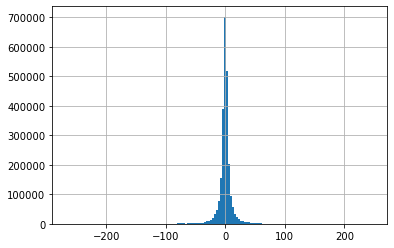

In [22]:
show['dif'].hist(bins=150)

<AxesSubplot:xlabel='dif', ylabel='Density'>

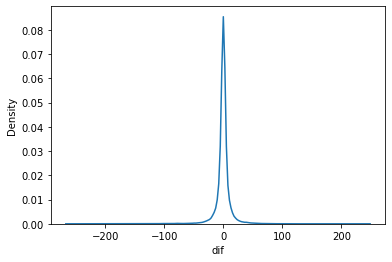

In [24]:
sns.kdeplot(show['dif'])

C:\Users\rkd20\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dif'>

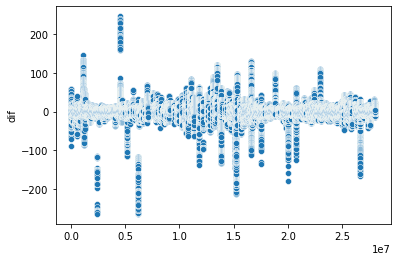

In [25]:
sns.scatterplot(show.index, show['dif'])

In [ ]:
explainer_1 = shap.Explainer(model1)
shap_values = explainer_1(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, max_display=10)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type='bar',max_display = 10)

In [ ]:
importances = model1.feature_importances_
importances

In [ ]:

sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()